# Part 3

In [5]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import time
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_tensor,resize
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
#loading and splitting the data

# Image transformations
transform = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])


# Loading the dataset and assigning the tagets to each class
dataset = torchvision.datasets.ImageFolder(root='/content/dset',transform=transform)


#splitting the data into train data of size 18000, and validation data and testing data of size 6000 each
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset,[18000,6000,6000])

# loading the data to loader using the dataloader of torch
traindata_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True)
validationdata_loader = torch.utils.data.DataLoader(val_dataset,batch_size=64,shuffle=True)
testdata_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True)

# Printing the targets assignined to each class of data
print(dataset.class_to_idx)

{'dogs': 0, 'food': 1, 'vehicles': 2}


In [11]:
# Calculating the statistics of data for the random sample of 500 images

data_tensor = torch.stack([img for i, (img, _) in enumerate(dataset) if i < 500])

data_mean = data_tensor.mean(dim=[0, 2, 3])
data_std = data_tensor.std(dim=[0, 2, 3])
data_var = data_tensor.var(dim=[0, 2, 3])
data_min = data_tensor.view(data_tensor.shape[0], -1).min(dim=1).values
data_max = data_tensor.view(data_tensor.shape[0], -1).max(dim=1).values
print("mean: {}\nstandard deviation: {} \nvariance: {}\nmin value: {} \nmax value:{}".format(data_mean,data_std,data_var,data_min,data_max))

mean: tensor([0.4926, 0.4446, 0.3957])
standard deviation: tensor([0.2651, 0.2554, 0.2572]) 
variance: tensor([0.0703, 0.0652, 0.0662])
min value: tensor([0.0078, 0.0314, 0.0000, 0.0000, 0.0078, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0039, 0.0000, 0.0000, 0.0000, 0.0157, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0157, 0.0000, 0.0000, 0.0275, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0078, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0118,
        0.0000, 0.0039, 0.0039, 0.0000, 0.0000, 0.0078, 0.0078, 0.0000, 0.0000,
        0.0000, 0.0784, 0.0000, 0.0000, 0.0196, 0.0000, 0.0000, 0.0078, 0.0039,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0118, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0039, 0.0000, 0.0039, 0.0667, 0.0000, 0.0157, 0.0000,
        0.0000, 0.0000, 0.0118, 0.0000, 0.0000, 0.000

In [9]:
data_min = data_tensor.view(data_tensor.shape[0], -1).min(dim=1).values
data_max = data_tensor.view(data_tensor.shape[0], -1).max(dim=1).values

## Plot1: Plotting a scatter comparing the width and heights of all images

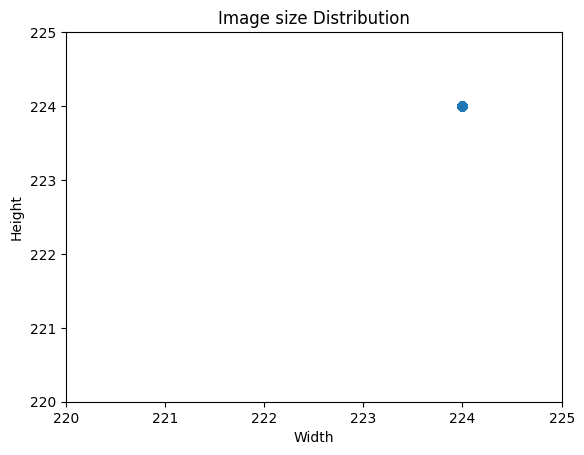

In [ ]:
image_sizes = []
for image, _ in dataset:
    width, height = image.size
    image_sizes.append((width, height))
image_sizes = np.array(image_sizes)
plt.scatter(image_sizes[:, 0], image_sizes[:,1])
plt.xlabel('Width')
plt.xlim(220,225)
plt.ylabel('Height')
plt.ylim(220,225)
plt.title('Image size Distribution')
plt.show()

## Plot 2 : histogram plotted for the pixel intensities for 1000 images

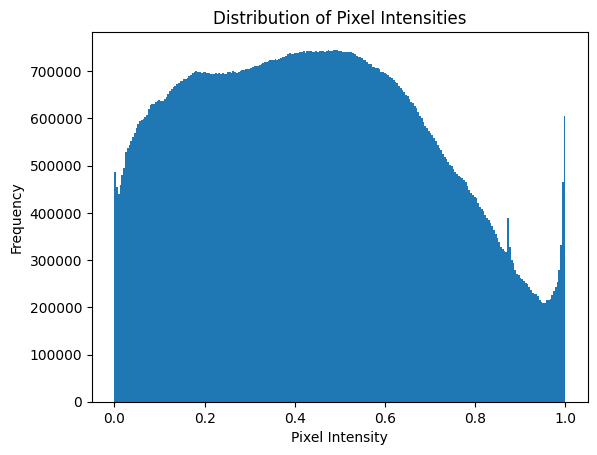

In [ ]:
pixel_intensities = []
jkl=0

# Loop over all the images in the dataset and get their pixel intensities
for image,label in dataset:
    jkl+=1
    image_np = np.array(image)
    pixel_intensities.extend(image_np.flatten().tolist())
    if(jkl == 1000):
        break
# Convert the list of pixel intensities to a numpy array
pixel_intensities = np.array(pixel_intensities)
# Plot the distribution of pixel intensities
plt.hist(pixel_intensities, bins=256)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Distribution of Pixel Intensities')
plt.show()

## Plot3 : Plotting an histogram to observe the number of samples taken for training from ecah class

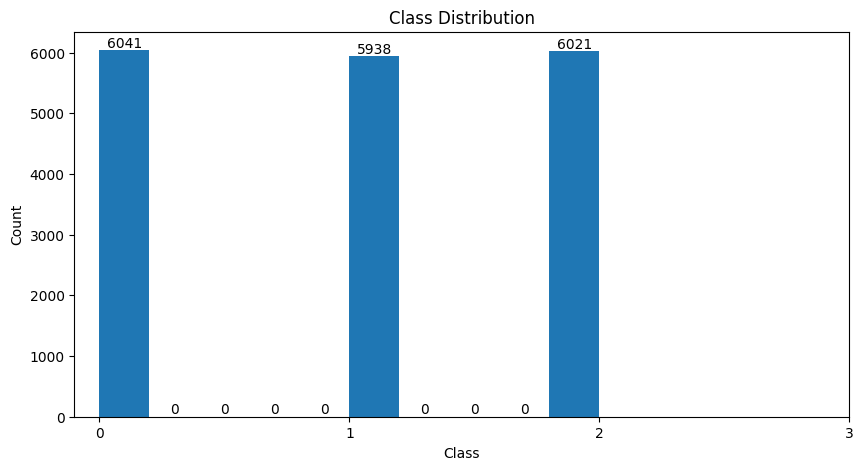

In [ ]:
fig = plt.figure(figsize=(10, 5))
lables=[]
for i, (images, labels) in enumerate(traindata_loader):
  
  lables = lables + list(labels)
counts, edges, bars = plt.hist(lables)

plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(range(4))
plt.title("Class Distribution")
plt.bar_label(bars)
plt.show()

In [ ]:
# Building the Alex net model

class AlexNet(nn.Module):
    def __init__(self,num_classes=10):
        super(AlexNet,self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),nn.BatchNorm2d(96),nn.ReLU(),nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2nn.BatchNorm2d(256),nn.ReLU(),nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(384),nn.ReLU())
        self.layer4 = nn.Sequential(nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(384),nn.ReLU())
        self.layer5 = nn.Sequential(nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(256),nn.ReLU(),nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(nn.Dropout(0.5),nn.Linear(6400, 4096),nn.ReLU())
        self.fc1 = nn.Sequential(nn.Dropout(0.5),nn.Linear(4096, 4096),nn.ReLU())
        self.fc2= nn.Sequential(nn.Linear(4096, num_classes))
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0),-1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


## model with ADAM and increasing learning rate  lr=0.005

In [ ]:
#Loading the Alexnet to our model and using the crossEntrophyLoass() to calculate the loss in each step in epoch and ADAM optimizer to update the weights

classes =3
epochs =25
learning_rate = 0.005

model = AlexNet(classes).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.005)

In [ ]:
#training the model
train_accuracies = []
test_accuracies = []
start_time= time.time()
for epoch in range(epochs):
    print("Epoch: {}".format(epoch+1))
    for i, (images, labels) in enumerate(traindata_loader):  
        # loading the tensors to the device
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass the model
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backward and optimize to update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))      
  # validating the model on the validation set images for each epoch

    correct = 0
    total = 0
    for images,labels in validationdata_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        dummydata, predicted = torch.max(outputs.data, 1)
        total = total+labels.size(0)
        correct = correct+(predicted == labels).sum().item()
        del images, labels, outputs
        correct1 = 0
    total1 = 0
    for images,labels in testdata_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        dummydata, predicted = torch.max(outputs.data, 1)
        total1 += labels.size(0)
        correct1 += (predicted == labels).sum().item()
        del images, labels, outputs
    print('for epoch {} validated on {} images train accuracy: {} % test accuracy: {} %'.format(epoch+1,total,round(100*correct/total,2),round(100*correct1/total1,2)))

    train_accuracies.append(round(100*correct/total,2))
    test_accuracies.append(round(100*correct1/total1,2)) 
end_time=time.time()
#testing the model for the test accuracy

correct1 = 0
total1 = 0
for images, labels in testdata_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    dummydata, predicted = torch.max(outputs.data, 1)
    total1 += labels.size(0)
    correct1 += (predicted == labels).sum().item()
    del images, labels, outputs
print('final model accuracy on the {} testing images: {} %'.format(total1,100*correct1/total1)) 
print("training time: {} min".format(round(end_time-start_time,2)/60))

Epoch: 1
for epoch 1 validated on 6000 images train accuracy: 63.82 % test accuracy: 62.77 %
Epoch: 2
for epoch 2 validated on 6000 images train accuracy: 80.23 % test accuracy: 78.93 %
Epoch: 3
for epoch 3 validated on 6000 images train accuracy: 80.27 % test accuracy: 78.72 %
Epoch: 4
for epoch 4 validated on 6000 images train accuracy: 83.47 % test accuracy: 81.82 %
Epoch: 5
for epoch 5 validated on 6000 images train accuracy: 82.35 % test accuracy: 80.88 %
Epoch: 6
for epoch 6 validated on 6000 images train accuracy: 84.58 % test accuracy: 84.07 %
Epoch: 7
for epoch 7 validated on 6000 images train accuracy: 83.47 % test accuracy: 82.47 %
Epoch: 8
for epoch 8 validated on 6000 images train accuracy: 86.85 % test accuracy: 85.73 %
Epoch: 9
for epoch 9 validated on 6000 images train accuracy: 84.93 % test accuracy: 82.72 %
Epoch: 10
for epoch 10 validated on 6000 images train accuracy: 85.25 % test accuracy: 85.08 %
Epoch: 11
for epoch 11 validated on 6000 images train accuracy: 88.1

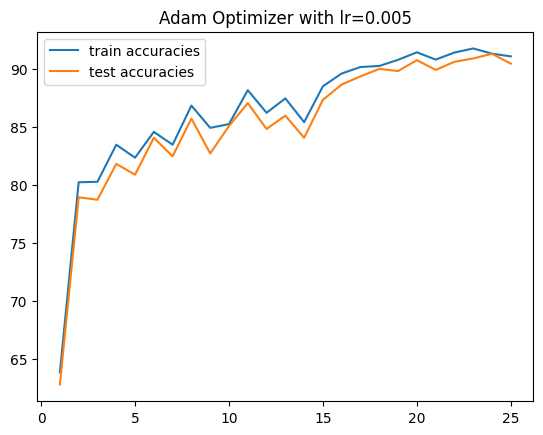

In [ ]:
plt.plot(range(1,26),train_accuracies, label = "train accuracies")
plt.plot(range(1,26),test_accuracies, label = "test accuracies")
plt.legend()
plt.title("Adam Optimizer with lr=0.005")
plt.show()

In [ ]:
#Loading the Alexnet to our model and using the crossEntrophyLoass() to calculate the loss in each step in epoch and ADAM optimizer to update the weights

classes =3
epochs =25
learning_rate = 0.01
model = AlexNet(classes).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.01)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  
# Train the model


In [ ]:
#training the model
train_accuracies = []
test_accuracies = []
start_time= time.time()
for epoch in range(epochs):
    print("Epoch: {}".format(epoch+1))
    for i, (images, labels) in enumerate(traindata_loader):  
        # loading the tensors to the device
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass the model
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backward and optimize to update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))      
  # validating the model on the validation set images for each epoch

    correct = 0
    total = 0
    for images,labels in validationdata_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        dummydata, predicted = torch.max(outputs.data, 1)
        total = total+labels.size(0)
        correct = correct+(predicted == labels).sum().item()
        del images, labels, outputs
        correct1 = 0
    total1 = 0
    for images,labels in testdata_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        dummydata, predicted = torch.max(outputs.data, 1)
        total1 += labels.size(0)
        correct1 += (predicted == labels).sum().item()
        del images, labels, outputs
    print('for epoch {} validated on {} images train accuracy: {} % test accuracy: {} %'.format(epoch+1,total,round(100*correct/total,2),round(100*correct1/total1,2)))

    train_accuracies.append(round(100*correct/total,2))
    test_accuracies.append(round(100*correct1/total1,2)) 
end_time=time.time()
#testing the model for the test accuracy

correct1 = 0
total1 = 0
for images, labels in testdata_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    dummydata, predicted = torch.max(outputs.data, 1)
    total1 += labels.size(0)
    correct1 += (predicted == labels).sum().item()
    del images, labels, outputs
print('final model accuracy on the {} testing images: {} %'.format(total1,100*correct1/total1)) 
print("training time: {} min".format(round(end_time-start_time,2)/60))

Epoch: 1
for epoch 1 validated on 6000 images train accuracy: 58.82 % test accuracy: 60.08 %
Epoch: 2
for epoch 2 validated on 6000 images train accuracy: 63.63 % test accuracy: 62.82 %
Epoch: 3
for epoch 3 validated on 6000 images train accuracy: 67.68 % test accuracy: 67.65 %
Epoch: 4
for epoch 4 validated on 6000 images train accuracy: 67.37 % test accuracy: 67.08 %
Epoch: 5
for epoch 5 validated on 6000 images train accuracy: 71.72 % test accuracy: 71.18 %
Epoch: 6
for epoch 6 validated on 6000 images train accuracy: 72.2 % test accuracy: 72.28 %
Epoch: 7
for epoch 7 validated on 6000 images train accuracy: 75.47 % test accuracy: 75.58 %
Epoch: 8
for epoch 8 validated on 6000 images train accuracy: 78.95 % test accuracy: 77.42 %
Epoch: 9
for epoch 9 validated on 6000 images train accuracy: 75.3 % test accuracy: 74.3 %
Epoch: 10
for epoch 10 validated on 6000 images train accuracy: 81.73 % test accuracy: 80.52 %
Epoch: 11
for epoch 11 validated on 6000 images train accuracy: 76.77 %

## Plotting graph between train and test accuracies

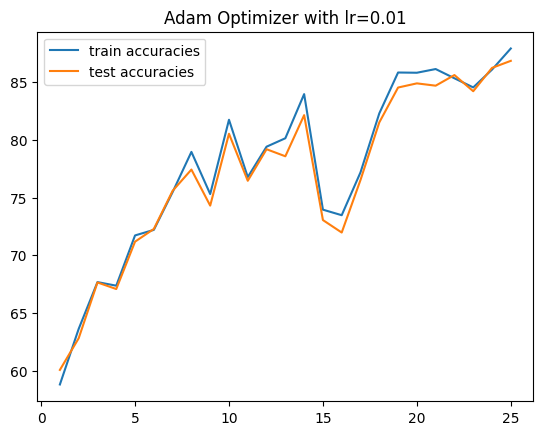

In [ ]:
plt.plot(range(1,26),train_accuracies, label = "train accuracies")
plt.plot(range(1,26),test_accuracies, label = "test accuracies")
plt.legend()
plt.title("Adam Optimizer with lr=0.01")
plt.show()

## improvising the model to improve accuracy with SGD optimizer and learning rate is lr=0.005

In [ ]:
classes =3
epochs =5

model = AlexNet(classes).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer=torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  
# Train the model

In [ ]:
#training the model
train_accuracies = []
test_accuracies = []
start_time= time.time()
for epoch in range(epochs):
    print("Epoch: {}".format(epoch+1))
    for i, (images, labels) in enumerate(traindata_loader):  
        # loading the tensors to the device
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass the model
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backward and optimize to update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))      
  # validating the model on the validation set images for each epoch

    correct = 0
    total = 0
    for images,labels in validationdata_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        dummydata, predicted = torch.max(outputs.data, 1)
        total = total+labels.size(0)
        correct = correct+(predicted == labels).sum().item()
        del images, labels, outputs
        correct1 = 0
    total1 = 0
    for images,labels in testdata_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        dummydata, predicted = torch.max(outputs.data, 1)
        total1 += labels.size(0)
        correct1 += (predicted == labels).sum().item()
        del images, labels, outputs
    print('for epoch {} validated on {} images train accuracy: {} % test accuracy: {} %'.format(epoch+1,total,round(100*correct/total,2),round(100*correct1/total1,2)))

    train_accuracies.append(round(100*correct/total,2))
    test_accuracies.append(round(100*correct1/total1,2)) 
end_time=time.time()
#testing the model for the test accuracy

correct1 = 0
total1 = 0
for images, labels in testdata_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    dummydata, predicted = torch.max(outputs.data, 1)
    total1 += labels.size(0)
    correct1 += (predicted == labels).sum().item()
    del images, labels, outputs
print('final model accuracy on the {} testing images: {} %'.format(total1,100*correct1/total1)) 
print("training time: {} min".format(round(end_time-start_time,2)/60))

Epoch: 1
for epoch 1 validated on 6000 images train accuracy: 86.12 % test accuracy: 84.73 %
Epoch: 2
for epoch 2 validated on 6000 images train accuracy: 89.02 % test accuracy: 87.37 %
Epoch: 3
for epoch 3 validated on 6000 images train accuracy: 88.85 % test accuracy: 88.6 %
Epoch: 4
for epoch 4 validated on 6000 images train accuracy: 90.62 % test accuracy: 89.77 %
Epoch: 5
for epoch 5 validated on 6000 images train accuracy: 90.9 % test accuracy: 90.83 %
final model accuracy on the 6000 testing images: 90.7 %
training time: 5.005833333333333 min


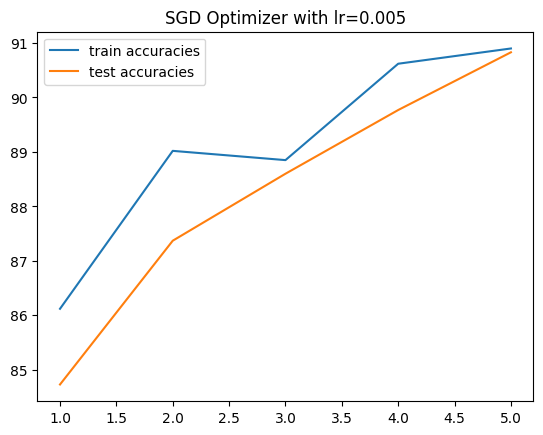

In [ ]:
plt.plot(range(1,6),train_accuracies, label = "train accuracies")
plt.plot(range(1,6),test_accuracies, label = "test accuracies")
plt.legend()
plt.title("SGD Optimizer with lr=0.005")
plt.show()

### Adding gradient clipping functionality to the model with SGD

In [ ]:
classes =3
epochs =5

model = AlexNet(classes).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, weight_decay = 0.005, momentum = 0.9)  
# Train the model
#training the model
train_accuracies = []
test_accuracies = []
start_time= time.time()
for epoch in range(epochs):
    print("Epoch: {}".format(epoch+1))
    for i, (images, labels) in enumerate(traindata_loader):  
        # loading the tensors to the device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass the model
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize to update the weights
        optimizer.zero_grad()
        loss.backward()
        clipping_value = 1
        torch.nn.utils.clip_grad_norm_(model.parameters(), clipping_value)
        optimizer.step()
        #print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
  # validating the model on the validation set images for each epoch

    correct = 0
    total = 0
    for images, labels in validationdata_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        dummydata, predicted = torch.max(outputs.data, 1)
        total = total+labels.size(0)
        correct = correct+(predicted == labels).sum().item()
        del images, labels, outputs
    correct1 = 0
    total1 = 0
    for images, labels in testdata_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        dummydata, predicted = torch.max(outputs.data, 1)
        total1 += labels.size(0)
        correct1 += (predicted == labels).sum().item()
        del images, labels, outputs
    print('for epoch {} validated on {} images train accuracy: {} % test accuracy: {} %'.format(epoch+1,total,round(100*correct/total,2),round(100*correct1/total1,2)))

    train_accuracies.append(round(100*correct/total,2))
    test_accuracies.append(round(100*correct1/total1,2)) 
end_time=time.time()
#testing the model for the test accuracy

correct1 = 0
total1 = 0
for images, labels in testdata_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    dummydata, predicted = torch.max(outputs.data, 1)
    total1 += labels.size(0)
    correct1 += (predicted == labels).sum().item()
    del images, labels, outputs
print('final model accuracy on the {} testing images: {} %'.format(total1,100*correct1/total1)) 

print("training time: {} min".format(round(end_time-start_time,2)/60))



Epoch: 1
for epoch 1 validated on 6000 images train accuracy: 85.75 % test accuracy: 85.42 %
Epoch: 2
for epoch 2 validated on 6000 images train accuracy: 88.27 % test accuracy: 87.77 %
Epoch: 3
for epoch 3 validated on 6000 images train accuracy: 90.28 % test accuracy: 90.17 %
Epoch: 4
for epoch 4 validated on 6000 images train accuracy: 90.15 % test accuracy: 89.92 %
Epoch: 5
for epoch 5 validated on 6000 images train accuracy: 90.8 % test accuracy: 90.67 %
final model accuracy on the 6000 testing images: 90.6 %
training time: 6.171666666666667 min


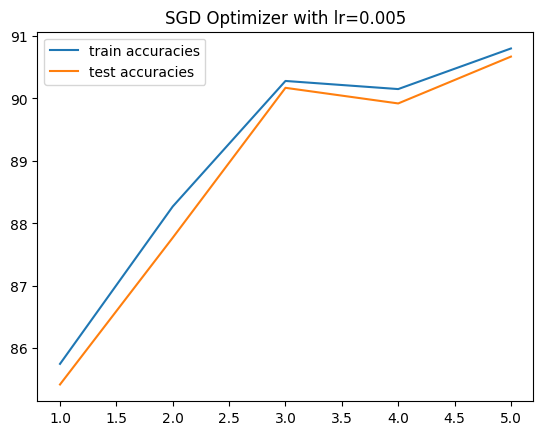

In [ ]:
plt.plot(range(1,6),train_accuracies, label = "train accuracies")
plt.plot(range(1,6),test_accuracies, label = "test accuracies")
plt.legend()
plt.title("SGD Optimizer with lr=0.005")
plt.show()

#### Finally we can summarize that the model with the SGD optimizer and the lr=0.005 is yeilding best results. So we will be using the same model in the future

# Part 4

In [14]:
#loading the data and splitting the data into test, train, validation sets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((227,227)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform2 = transforms.Compose([
    transforms.RandomCrop((32, 32), padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Resize((227,227)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])
train_set1 = datasets.SVHN(root='./svhndata', split='train', download=True, transform=transform)
train_set2 = datasets.SVHN(root='./svhndata', split='train', download=True, transform=transform2)
test_set = datasets.SVHN(root='./svhndata', split='test', download=True, transform=transform)

#with augumentation
train_set = train_set1 + train_set2
train_size = len(train_set)
val_size = int(0.1 * train_size)
indices = list(range(train_size))
np.random.shuffle(indices)
train_sampler = SubsetRandomSampler(indices[val_size:])
val_sampler = SubsetRandomSampler(indices[:val_size])

#without augumentation
train_size1 = len(train_set1)
val_size1 = int(0.1 * train_size1)
indices1 = list(range(train_size1))
np.random.shuffle(indices1)
train_sampler1 = SubsetRandomSampler(indices1[val_size1:])
val_sampler1 = SubsetRandomSampler(indices1[:val_size1])

#train_loader and validation loader without the data augumentation
train_loader = torch.utils.data.DataLoader(train_set1, batch_size=64, sampler=train_sampler1)
val_loader = torch.utils.data.DataLoader(train_set1, batch_size=64, sampler=val_sampler1)

#train_loader and validation loader with the data augumentation
train_loader2 = torch.utils.data.DataLoader(train_set, batch_size=64, sampler=train_sampler)
val_loader2 = torch.utils.data.DataLoader(train_set, batch_size=64, sampler=val_sampler)

#test data loader
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)



Using downloaded and verified file: ./svhndata/train_32x32.mat
Using downloaded and verified file: ./svhndata/train_32x32.mat
Using downloaded and verified file: ./svhndata/test_32x32.mat


In [16]:
# Calculating the statistics of data for the random sample of 500 images

data_tensor = torch.stack([img for i, (img, _) in enumerate(train_set1) if i < 500])
data_mean = data_tensor.mean(dim=[0, 2, 3])
data_std = data_tensor.std(dim=[0, 2, 3])
data_var = data_tensor.var(dim=[0, 2, 3])
data_min = data_tensor.view(data_tensor.shape[0], -1).min(dim=1).values
data_max = data_tensor.view(data_tensor.shape[0], -1).max(dim=1).values
print("mean: {}\nstandard deviation: {} \nvariance: {}\nmin value: {} \nmax value:{}".format(data_mean,data_std,data_var,data_min,data_max))

mean: tensor([-0.0877, -0.0764, -0.0306])
standard deviation: tensor([0.4101, 0.4213, 0.4186]) 
variance: tensor([0.1682, 0.1775, 0.1752])
min value: tensor([-0.9023, -0.8743, -0.9179, -0.9216, -0.4701, -0.4341, -0.6862, -0.7013,
        -0.8579, -0.8975, -0.7306, -0.8588, -0.9130, -0.6207, -0.1994, -0.2692,
        -0.8275, -0.5294, -0.5095, -0.5159, -0.8225, -0.9028, -0.7784, -0.7640,
        -0.9638, -0.9586, -1.0000, -0.9999, -0.4847, -0.6414, -0.4715, -0.4724,
        -0.2703,  0.0614, -0.9399, -0.9567, -0.5633, -0.0818, -0.3993, -0.2619,
        -0.7995, -0.7409, -0.9214, -0.8100, -0.4353, -0.4248, -0.3412, -1.0000,
        -1.0000, -0.9259, -0.9137, -0.6300, -0.6376, -0.6332, -0.2078, -0.1285,
        -0.9346, -0.9357, -0.5176, -0.7412, -0.8413, -0.8421, -0.6523, -0.8353,
        -0.9133, -0.5641, -0.5278, -0.4662, -0.6474, -0.6235, -0.9842, -0.9888,
        -0.8526, -0.8986, -0.3557, -0.8869, -0.8800, -0.5921, -0.6314, -0.8906,
        -0.8935, -0.7221, -0.7291, -0.5889, -0.615

## Data Visualization

## Plot 1 histogragm describing the class distribution

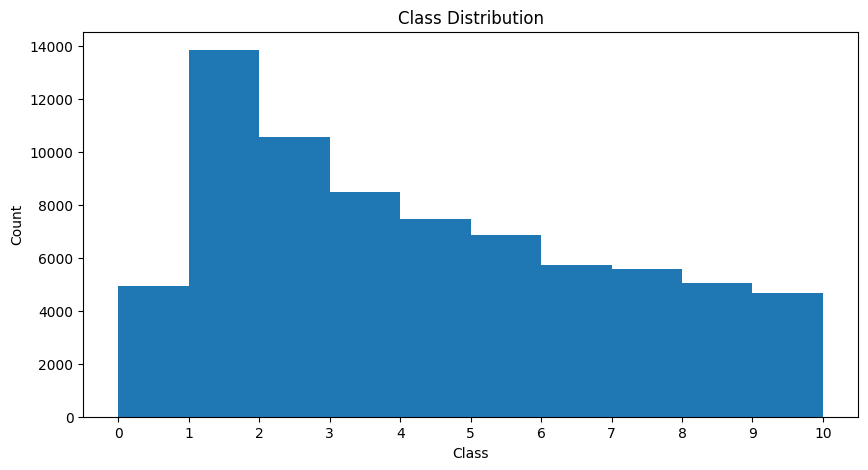

In [ ]:
fig = plt.figure(figsize=(10, 5))
plt.hist(train_set.labels, bins=range(11))
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(range(11))
plt.title("Class Distribution")
plt.show()

## plot 2 Box plot to observe the images widths in diffrent classes

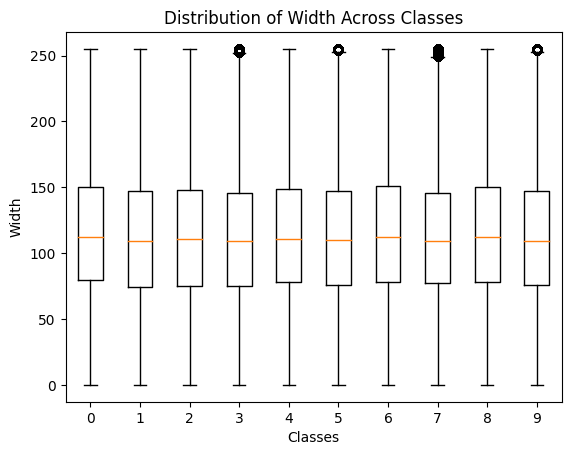

In [ ]:
plt.boxplot([train_set1.data[train_set1.labels == i][:, :, :, 0].reshape(-1) for i in range(10)])
plt.xticks(range(1, 11), range(10))
plt.xlabel('Classes')
plt.ylabel('Width')
plt.title('Distribution of Width Across Classes')
plt.show()

## plot 3- Scatter plots giving an overview of maximum images width and height

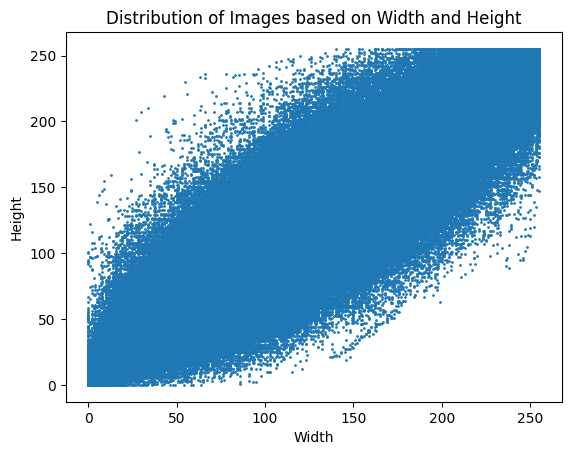

In [ ]:
width = train_set.data.shape[1]
height = train_set.data.shape[2]

plt.scatter(train_set.data[:, :, :, 0].reshape(-1), train_set.data[:, :, :, 1].reshape(-1), s=1)
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Distribution of Images based on Width and Height')
plt.show()

In [ ]:
# Building the Alex net model

class AlexNet(nn.Module):
    def __init__(self,num_classes=10):
        super(AlexNet,self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),nn.BatchNorm2d(96),nn.ReLU(),nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2nn.BatchNorm2d(256),nn.ReLU(),nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(384),nn.ReLU())
        self.layer4 = nn.Sequential(nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(384),nn.ReLU())
        self.layer5 = nn.Sequential(nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(256),nn.ReLU(),nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(nn.Dropout(0.5),nn.Linear(9216, 4096),nn.ReLU())
        self.fc1 = nn.Sequential(nn.Dropout(0.5),nn.Linear(4096, 4096),nn.ReLU())
        self.fc2= nn.Sequential(nn.Linear(4096, num_classes))     
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0),-1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


In [ ]:
#Loading the Alexnet to our model and using the crossEntrophyLoass() to calculate the loss in each step in epoch and SGD optimizer to update the weights

classes =10
epochs =5
learning_rate = 0.005

model = AlexNet(classes).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer=torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  


## Model 1 Without any data augumentation

In [ ]:
#training the model with data without data augumentation
train_accuracies = []
test_accuracies = []
start_time= time.time()
for epoch in range(epochs):
    print("Epoch: {}".format(epoch+1))
    for i, (images, labels) in enumerate(train_loader):  
        # loading the tensors to the device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass the model
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize to update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
  # validating the model on the validation set images for each epoch

    correct = 0
    total = 0
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        dummydata, predicted = torch.max(outputs.data, 1)
        total = total+labels.size(0)
        correct = correct+(predicted == labels).sum().item()
        del images, labels, outputs
    correct1 = 0
    total1 = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        dummydata, predicted = torch.max(outputs.data, 1)
        total1 += labels.size(0)
        correct1 += (predicted == labels).sum().item()
        del images, labels, outputs
    print('for epoch {} validated on {} images train accuracy: {} % test accuracy: {} %'.format(epoch+1,total,round(100*correct/total,2),round(100*correct1/total1,2)))

    train_accuracies.append(round(100*correct/total,2))
    test_accuracies.append(round(100*correct1/total1,2)) 
end_time=time.time()

#testing the model for the test accuracy
correct1 = 0
total1 = 0
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    dummydata, predicted = torch.max(outputs.data, 1)
    total1 += labels.size(0)
    correct1 += (predicted == labels).sum().item()
    del images, labels, outputs
print('final model accuracy on the {} testing images: {} %'.format(total1,100*correct1/total1)) 

print("training time: {} min".format(round(end_time-start_time,2)/60))

Epoch: 1
for epoch 1 validated on 7325 images train accuracy: 87.82 % test accuracy: 86.67 %
Epoch: 2
for epoch 2 validated on 7325 images train accuracy: 90.1 % test accuracy: 89.19 %
Epoch: 3
for epoch 3 validated on 7325 images train accuracy: 91.09 % test accuracy: 90.8 %
Epoch: 4
for epoch 4 validated on 7325 images train accuracy: 91.93 % test accuracy: 91.47 %
Epoch: 5
for epoch 5 validated on 7325 images train accuracy: 92.75 % test accuracy: 92.5 %
final model accuracy on the 26032 testing images: 92.30562384757222 %
training time: 22.14816666666667 min


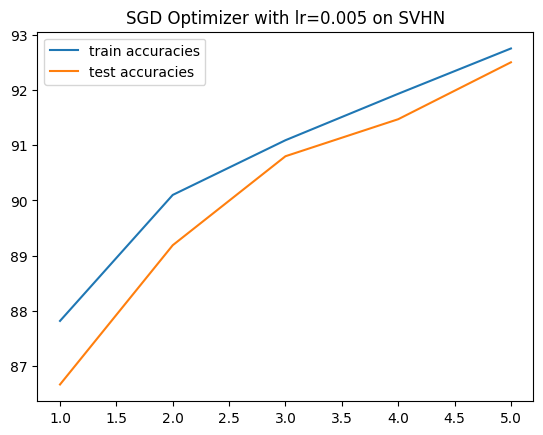

In [ ]:
plt.plot(range(1,6),train_accuracies, label = "train accuracies")
plt.plot(range(1,6),test_accuracies, label = "test accuracies")
plt.legend()
plt.title("SGD Optimizer with lr=0.005 on SVHN")
plt.show()

## Model 2 with the data augumentation

In [ ]:
#training the model with data without data augumentation
train_accuracies = []
test_accuracies = []
start_time= time.time()
for epoch in range(epochs):
    print("Epoch: {}".format(epoch+1))
    for i, (images, labels) in enumerate(train_loader):  
        # loading the tensors to the device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass the model
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize to update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
  # validating the model on the validation set images for each epoch

    correct = 0
    total = 0
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        dummydata, predicted = torch.max(outputs.data, 1)
        total = total+labels.size(0)
        correct = correct+(predicted == labels).sum().item()
        del images, labels, outputs
    correct1 = 0
    total1 = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        dummydata, predicted = torch.max(outputs.data, 1)
        total1 += labels.size(0)
        correct1 += (predicted == labels).sum().item()
        del images, labels, outputs
    print('for epoch {} validated on {} images train accuracy: {} % test accuracy: {} %'.format(epoch+1,total,round(100*correct/total,2),round(100*correct1/total1,2)))

    train_accuracies.append(round(100*correct/total,2))
    test_accuracies.append(round(100*correct1/total1,2)) 
end_time=time.time()
#testing the model for the test accuracy

correct1 = 0
total1 = 0
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    dummydata, predicted = torch.max(outputs.data, 1)
    total1 += labels.size(0)
    correct1 += (predicted == labels).sum().item()
    del images, labels, outputs
print('final model accuracy on the {} testing images: {} %'.format(total1,100*correct1/total1)) 

print("training time: {} min".format(round(end_time-start_time,2)/60))

Epoch: 1
for epoch 1 validated on 14651 images train accuracy: 83.36 % test accuracy: 86.78 %
Epoch: 2
for epoch 2 validated on 14651 images train accuracy: 86.2 % test accuracy: 88.89 %
Epoch: 3
for epoch 3 validated on 14651 images train accuracy: 89.5 % test accuracy: 91.69 %
Epoch: 4
for epoch 4 validated on 14651 images train accuracy: 90.25 % test accuracy: 92.45 %
Epoch: 5
for epoch 5 validated on 14651 images train accuracy: 89.99 % test accuracy: 92.37 %
final model accuracy on the 26032 testing images: 92.52074370006146 %
training time: 43.845166666666664 min


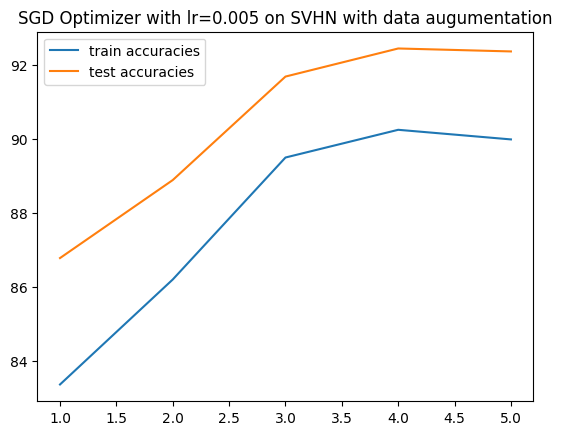

In [ ]:
plt.plot(range(1,6),train_accuracies, label = "train accuracies")
plt.plot(range(1,6),test_accuracies, label = "test accuracies")
plt.legend()
plt.title("SGD Optimizer with lr=0.005 on SVHN with data augumentation")
plt.show()

#### References

#### [1] https://blog.paperspace.com/alexnet-pytorch/

#### [2] https://www.aboutdatablog.com/post/how-to-successfully-add-large-data-sets-to-google-drive-and-use-them-in-google-colab 